# NLP case study


The following table summarizes the datasets used throughout this notebook.

| dataset ID | dataset name| is_dialectical | is_MSA (Modern Standard Arabic) | is_balanced | num_of_tweets | num_of_pos_tweets | num_of_neg_tweets |
|-- | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 1 | [arabic-sentiment-twitter-corpus](https://www.kaggle.com/mksaad/arabic-sentiment-twitter-corpus) | Yes | No/minority | Yes | 58,751 | 29,849 | 28,902  
| 2 |[SS2030](https://www.kaggle.com/snalyami3/arabic-sentiment-analysis-dataset-ss2030-dataset ) | Yes - Saudi dialect only | No/Minority | Yes | 4,252 | 2,436 | 1,816 
| 3 |[100k Arabic Reviews](https://www.kaggle.com/abedkhooli/arabic-100k-reviews ) | No/Minority | Yes | Yes | 66,666 | 33,333 | 33,333
| 4 | [ArSAS](https://homepages.inf.ed.ac.uk/wmagdy/resources.htm) | Yes - mixed dialects| No/Minority | Yes | 11,784 | 4,400 | 7,384

*(For a more detailed analysis of the datasets see [this](https://www.kaggle.com/yasmeenhany/dataset-analysis) companion notebook. )*



**[Importing the necessary modules](https://)**

In [1]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [1]:
import re
import io
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns

%matplotlib inline

### Importing the dataset


In [3]:
from google.colab import files
uploaded = files.upload()

Saving test_Arabic_tweets_negative_20190413.tsv to test_Arabic_tweets_negative_20190413.tsv
Saving test_Arabic_tweets_positive_20190413.tsv to test_Arabic_tweets_positive_20190413.tsv
Saving train_Arabic_tweets_negative_20190413.tsv to train_Arabic_tweets_negative_20190413.tsv
Saving train_Arabic_tweets_positive_20190413.tsv to train_Arabic_tweets_positive_20190413.tsv


In [2]:
pd.set_option('display.max_colwidth', 280)
pd.set_option('mode.chained_assignment', None)
train_neg = pd.read_csv("twitter/train_Arabic_tweets_negative_20190413.tsv", sep="\t", header=None,  quoting=csv.QUOTE_NONE)
train_pos = pd.read_csv("twitter/train_Arabic_tweets_positive_20190413.tsv", 
                        sep="\t", header=None,  quoting=csv.QUOTE_NONE)
train_neg.rename(columns={0:'label', 1:'tweet'}, inplace=True)
train_pos.rename(columns={0:'label', 1:'tweet'}, inplace=True)
train_neg['label'] = 0
train_pos['label'] = 1
twitter_train_df = pd.concat([train_neg, train_pos], axis=0).reset_index(drop=True)

### Visualizing the first 10 rows of the training dataset: 

In [3]:
twitter_train_df.head(10)

,label,tweet
0,0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭
1,0,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين احس فيه احد ناقصهم 💔 #Avlu
2,0,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال والاهلي تحت التاق 👇 #تحدي_اسرع_روقان وادخل في سحب قيمة ايفون X على…
3,0,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين على بكتيريا 🦠 فتنفجر 💥 و تموت . الأخيرة يبدو انها بكتيريا مقاومة فأخذ…
4,0,الدودو جايه تكمل علي 💔
5,0,أحببته حتى أقنعنى إن ما فات من العمر كان إنتظار له 🙈
6,0,يبدو ان دجلة اعتادت على التهام اجساد ابنائها من سبايكر للعبارة ..👆👆💔 ما سمعته .. ان البشر يعطش فيشرب الماء .. لم…
7,0,جالس أذاكر 😣
8,0,يكفي استخفاف بالعقل العربي هل حقا الأمن والمخابرات في ألمانيا غير قادرة على وقف اي عصابة أو الجريمة 🤔 وا…
9,0,ياليلل ترا اكلج كثير مشي 😭


### Loading the emoji database and setting up the NLTK Downloader






In [6]:
from google.colab import files
uploaded = files.upload()

Saving Emoji_Sentiment_Data.csv to Emoji_Sentiment_Data.csv


In [4]:
# Setup the data for emoji
df_emoji = pd.read_csv("Emoji_Sentiment_Data.csv", usecols = ['Emoji', 'Negative', 'Neutral', 'Positive'])
# compare the polarity of the dataset and turn the polarity to binary
# 0 = negative, 1= positive
polarity_ls = []
for index, row in df_emoji.iterrows():
    
    # polarity == sentiment
    # initial polarity is negative
    polarity = 0 
    
    # positive if positive value is greater than negative value
    arg_1 = row['Positive'] > row['Negative']
    
    # positive if neutral value is odd and positive and negative value are equal
    arg_2 = row['Positive'] == row['Negative'] and row['Neutral'] % 2 != 0 
    
    # positive if either of the two arguments are true
    if arg_1 or arg_2:
        polarity = 1
    polarity_ls.append(polarity)
    
# create new emoji dataset
new_df_emoji = pd.DataFrame(polarity_ls, columns=['sentiment'])
new_df_emoji['emoji'] = df_emoji['Emoji'].values
new_df_emoji

,sentiment,emoji
0,1,😂
1,1,❤
2,1,♥
3,1,😍
4,0,😭
...,...,...
964,1,➛
965,1,♝
966,1,❋
967,1,✆


In [8]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all-corpora


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
       |   Unzipping corpora/cess_esp.zip.
       | Downloading package chat80 to /root/nltk_data...
       |   Unzipping corpora/chat80.zip.
       | Downloading package city_database to /root/nltk_data...
       |   Unzipping corpora/city_database.zip.
       | Downloading package cmudict to /root/nltk_data...
  


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

### Preprocessing functions : these functions are used to extract the text features for the tweet row and creating a new dataframe composed of the old dataframe plus the new features

In [5]:
from nltk.corpus import stopwords
import emoji
#Stats about Text
def avg_word(sentence):
    words = sentence.split()
    if len(words) == 0:
        return 0
    return (sum(len(word) for word in words)/len(words))

def emoji_counter(sentence):
    return emoji.emoji_count(sentence)

In [6]:
def extract_text_and_emoji(text):
    # remove all tagging and links, not need for sentiments
    remove_keys = ('@', 'http://', '&', '#')
    clean_text = ' '.join(txt for txt in text.split() if not txt.startswith(remove_keys))
    #print(clean_text)
    
    # setup the input, get the characters and the emoji lists
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if emoji.is_emoji(c)]
    
    # extract text
    clean_text = ' '.join([str for str in clean_text.split() if not any(i in str for i in emoji_list)])
    
    # extract emoji
    clean_emoji = ''.join([str for str in text.split() if any(i in str for i in emoji_list)])
    return (emoji_list)

    

def get_polarity(text):
  """ get the Polarity of an emoji from the emoji_df """
  emoji_list = extract_text_and_emoji(text)
  # print('\nAll Emoji:',emoji_list)
  polarity = 0
  for emo in emoji_list:
    emo_pola = new_df_emoji[new_df_emoji.emoji == emo].sentiment
    # print(emo_pola.size)
    if(emo_pola.size != 0):
      polarity += emo_pola.values
  return polarity

In [7]:
get_polarity('😭')

array([0], dtype=int64)

### Feature engineering

In [8]:
def add_features(df):
    """ this function adds the 5 features to the dataframe """
    new_df = df.copy()
    new_df['word_count'] = new_df['tweet'].apply(lambda x: len(str(x).split(" ")))
    new_df['char_count'] = new_df['tweet'].str.len() 
    new_df['avg_char_per_word'] = new_df['tweet'].apply(lambda x: avg_word(x))
    new_df['emoji_count'] = new_df['tweet'].apply(lambda x: emoji_counter(x))
    return new_df

In [9]:
def add_polarity(df):
  """ add emoji polarity to each row of the train dataset"""
  new_df = df.copy()
  new_df['polarity'] = 0
  for index, row in new_df.iterrows():
	  pol=get_polarity(row['tweet'])
	  new_df['polarity'][index]=pol
  return new_df

In [11]:
twitter_train_df_with_features = add_polarity(twitter_train_df)
twitter_train_df_with_features = add_features(twitter_train_df_with_features)

In [12]:
twitter_train_df_with_features.head(10)

,label,tweet,polarity,word_count,char_count,avg_char_per_word,emoji_count
0,0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭,0,12,56,3.750000,1
1,0,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين احس فيه احد ناقصهم 💔 #Avlu,0,15,72,3.866667,1
2,0,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال والاهلي تحت التاق 👇 #تحدي_اسرع_روقان وادخل في سحب قيمة ايفون X على…,1,18,112,5.277778,1
3,0,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين على بكتيريا 🦠 فتنفجر 💥 و تموت . الأخيرة يبدو انها بكتيريا مقاومة فأخذ…,1,21,115,4.523810,3
4,0,الدودو جايه تكمل علي 💔,0,5,22,3.600000,1
5,0,أحببته حتى أقنعنى إن ما فات من العمر كان إنتظار له 🙈,1,12,52,3.416667,1
6,0,يبدو ان دجلة اعتادت على التهام اجساد ابنائها من سبايكر للعبارة ..👆👆💔 ما سمعته .. ان البشر يعطش فيشرب الماء .. لم…,2,22,113,4.181818,3
7,0,جالس أذاكر 😣,0,3,12,3.333333,1
8,0,يكفي استخفاف بالعقل العربي هل حقا الأمن والمخابرات في ألمانيا غير قادرة على وقف اي عصابة أو الجريمة 🤔 وا…,0,20,105,4.300000,1
9,0,ياليلل ترا اكلج كثير مشي 😭,0,6,26,3.500000,1


### Preprocessing the dataset

In [13]:
import string
punctuations_list = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    text = text.replace(punctuations_list,' ')
    return text


# def get_emojis(text):
#   emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#   return emoji_pattern.findall(text)

def remove_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def remove_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [14]:
def clean_text(text):
    stop = stopwords.words('arabic')
    text = remove_punctuations(text)
    text = remove_diacritics(text)
    text = normalize_arabic(text)
    text = remove_all_entities(text)
    text = remove_links(text)
    text = ' '.join(word for word in text.split() if word not in stop)
    text = re.sub(r'[A-Za-z0-9]', '', text)
    return text

In [15]:
twitter_train_df_with_features['tweet'] = twitter_train_df_with_features['tweet'].apply(clean_text)

### Here we have the old Dataset : 

In [16]:
twitter_train_df.head(10)

,label,tweet
0,0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭
1,0,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين احس فيه احد ناقصهم 💔 #Avlu
2,0,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال والاهلي تحت التاق 👇 #تحدي_اسرع_روقان وادخل في سحب قيمة ايفون X على…
3,0,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين على بكتيريا 🦠 فتنفجر 💥 و تموت . الأخيرة يبدو انها بكتيريا مقاومة فأخذ…
4,0,الدودو جايه تكمل علي 💔
5,0,أحببته حتى أقنعنى إن ما فات من العمر كان إنتظار له 🙈
6,0,يبدو ان دجلة اعتادت على التهام اجساد ابنائها من سبايكر للعبارة ..👆👆💔 ما سمعته .. ان البشر يعطش فيشرب الماء .. لم…
7,0,جالس أذاكر 😣
8,0,يكفي استخفاف بالعقل العربي هل حقا الأمن والمخابرات في ألمانيا غير قادرة على وقف اي عصابة أو الجريمة 🤔 وا…
9,0,ياليلل ترا اكلج كثير مشي 😭


### And the new Dataset looks like this

In [17]:
twitter_train_df_with_features.head(10)

,label,tweet,polarity,word_count,char_count,avg_char_per_word,emoji_count
0,0,اعترف ان بتس كانو شوي شوي يجيبو راسي اليوم بالزايد 😭,0,12,56,3.750000,1
1,0,توقعت اذا جات داريا بشوفهم كاملين للحين احس احد ناقصهم 💔,0,15,72,3.866667,1
2,0,الهلال اكتب توقعك لنتيجه لقاء الهلال والاهلي التاق 👇 اسرع روقان وادخل سحب قيمه ايفون علي…,1,18,112,5.277778,1
3,0,نعمه المضادات الحيويه تضع قطره💧مضاد بنسلين علي بكتيريا 🦠 فتنفجر 💥 تموت الاخيره يبدو انها بكتيريا مقاومه فاخذ…,1,21,115,4.523810,3
4,0,الدودو جايه تكمل علي 💔,0,5,22,3.600000,1
5,0,احببته حتي اقنعني ان فات العمر انتظار 🙈,1,12,52,3.416667,1
6,0,يبدو ان دجله اعتادت علي التهام اجساد ابناءها سبايكر للعباره 👆👆💔 سمعته ان البشر يعطش فيشرب الماء لم…,2,22,113,4.181818,3
7,0,جالس اذاكر 😣,0,3,12,3.333333,1
8,0,يكفي استخفاف بالعقل العربي الامن والمخابرات المانيا قادره علي وقف اي عصابه او الجريمه 🤔 وا…,0,20,105,4.300000,1
9,0,ياليلل ترا اكلج كثير مشي 😭,0,6,26,3.500000,1


In [ ]:
uploaded = files.upload()

### Importing the test set and applying modifications on it

In [18]:
test_pos = pd.read_csv("twitter/test_Arabic_tweets_positive_20190413.tsv", 
                       sep="\t", header=None,  quoting=csv.QUOTE_NONE)
test_neg = pd.read_csv("twitter/test_Arabic_tweets_negative_20190413.tsv", 
                       sep="\t", header=None,  quoting=csv.QUOTE_NONE)
test_pos.rename(columns={0:'label', 1:'tweet'}, inplace=True)
test_neg.rename(columns={0:'label', 1:'tweet'}, inplace=True)
test_neg['label']=0
test_pos['label']=1
twitter_test_df = pd.concat([test_neg, test_pos], axis=0).reset_index(drop=True)
twitter_test_df_with_features = twitter_test_df.copy()
twitter_test_df_with_features = add_features(twitter_test_df_with_features)
twitter_test_df_with_features = add_polarity(twitter_test_df_with_features)
twitter_test_df_with_features['tweet'] = twitter_test_df_with_features['tweet'].apply(clean_text)

In [19]:
twitter_test_df

,label,tweet
0,0,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
1,0,واحد تبع النظام السوري يقول أن المخابرات السورية وراء تحطم مركبة إسرائيلية على سطح القمر 😳 أول مرة أعرف أن القمر أق…
2,0,الى متى التعامل السئ للخادمات وعدم احترامهم وكأنهم حشرات والله هالمواقف تصير بيننا ونشوفها المربية جات من بيتها مع…
3,0,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي
4,0,تتمغط ومعها سداع 😫
...,...,...
11746,1,ربي اغفر لي و لوالدي و لأحبتي و للمؤمنين و المؤمنات و المسلمين و المسلمات الأحياء منهم و الأموات :)
11747,1,ربي يسعدنا وياكم 💛
11748,1,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الرياضية أليمة ومخجلة نختلف ونتفق حول حسين ولكن المؤكد أن صحيفته الأخلاق…
11749,1,صباحكم احتفالية لم تكتمل، وصاحب الاحتفاليه ماكمل المباراة برضوه..اجل بتغبن جمهور الهلال 😂


In [20]:
twitter_test_df_with_features

,label,tweet,word_count,char_count,avg_char_per_word,emoji_count,polarity
0,0,حتي الايتونز خربتوه مو صاحين انتو؟؟ 😭,7,37,4.428571,1,0
1,0,تبع النظام السوري يقول ان المخابرات السوريه وراء تحطم مركبه اسراءيليه علي سطح القمر 😳 اول مره اعرف ان القمر اق…,22,116,4.318182,1,1
2,0,الي متي التعامل السء للخادمات وعدم احترامهم وكانهم حشرات والله هالمواقف تصير بيننا ونشوفها المربيه جات بيتها مع…,19,115,5.105263,0,0
3,0,رايح جاي طحلبي 🐸 الاهلي,6,33,4.666667,1,0
4,0,تتمغط ومعها سداع 😫,4,18,3.750000,1,0
...,...,...,...,...,...,...,...
11746,1,ربي اغفر لوالدي لاحبتي للمءمنين المءمنات المسلمين المسلمات الاحياء منهم الاموات,20,99,4.000000,0,0
11747,1,ربي يسعدنا وياكم 💛,4,18,3.750000,1,1
11748,1,يتحدثون اخلاق حسين ونجوم فرقهم نهاياتهم الرياضيه اليمه ومخجله نختلف ونتفق حول حسين المءكد ان صحيفته الاخلاق…,19,116,5.157895,0,0
11749,1,صباحكم احتفاليه تكتمل، وصاحب الاحتفاليه ماكمل المباراه برضوه اجل بتغبن جمهور الهلال 😂,13,89,5.923077,1,1


### Splitting the data

In [21]:
#old train split
X = twitter_train_df.tweet.values
y = twitter_train_df.label.values

#old test split
X_test = twitter_test_df.tweet.values
y_test = twitter_test_df.label.values


### Old model definition

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

def train_model(model, data, targets):
    text_clf = Pipeline([
      ('vect', CountVectorizer()),
      ('tfidf', TfidfTransformer()),
      ('clf', model),
    ])
    text_clf.fit(data, targets)
    return text_clf
def get_accuracy(trained_model,X, y):
    predicted = trained_model.predict(X)
    accuracy = np.mean(predicted == y)
    return accuracy

### Old model metrics

In [23]:
old_model = train_model(MultinomialNB(), X, y)
test_accuracy = get_accuracy(old_model,X_test, y_test)
print(f"test accuracy with MultinomialNB: {test_accuracy:.4f}")

test accuracy with MultinomialNB: 0.7870


### Since we are using Cross validation we can merge the two datasets(train and test) and use it as a training set for the model

In [24]:
text_features = ['tweet']
numerical_features = ['word_count','char_count','avg_char_per_word','emoji_count','polarity']
new_twitter_df =  twitter_train_df_with_features.append(twitter_test_df_with_features, ignore_index=True)

### Looking for negatively correlated features

In [25]:
(new_twitter_df.drop('tweet', axis=1).corr() < 0).any().any()

False

### plotting the feature correlation 

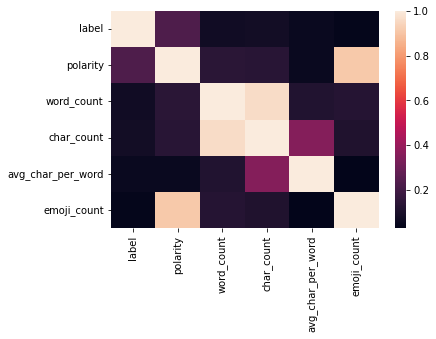

In [26]:
ax = sns.heatmap(new_twitter_df.drop('tweet', axis=1).corr())

### From the heatmap we can identify that word_count and char_count are highly correlated  so i decided to drop the char_count column since MultinomialNB assumes  that the features are independent

In [ ]:
new_twitter_df = new_twitter_df.drop('char_count', axis=1)

In [59]:
numerical_features.remove('char_count')

### Here i use a RandomForestClassifier as a benchmark model to extract the most important feature to pass it to the MultinomialNB model

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [63]:
rf = RandomForestClassifier(n_estimators=150)
rf.fit(new_twitter_df.drop(['tweet', 'label'], axis=1), new_twitter_df.label)
pred = rf.predict(twitter_test_df_with_features.drop(['tweet','label','char_count'], axis=1))
print(accuracy_score(pred, twitter_test_df_with_features.label))

0.501999829801719


Text(0.5, 0, 'Feature Importance')

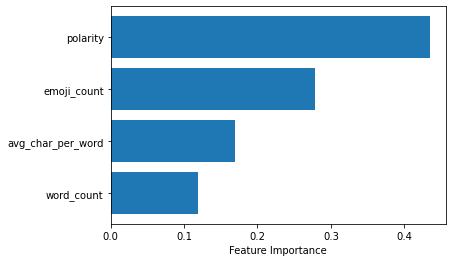

In [64]:
sort = rf.feature_importances_.argsort()
plt.barh(numerical_features, rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

### the new features are relatively important to the RandomForestClassifier so we will use them all in the MultinomialNB model

In [65]:
new_twitter_df

,label,tweet,polarity,word_count,avg_char_per_word,emoji_count
0,0,اعترف ان بتس كانو شوي شوي يجيبو راسي اليوم بالزايد 😭,0,12,3.750000,1
1,0,توقعت اذا جات داريا بشوفهم كاملين للحين احس احد ناقصهم 💔,0,15,3.866667,1
2,0,الهلال اكتب توقعك لنتيجه لقاء الهلال والاهلي التاق 👇 اسرع روقان وادخل سحب قيمه ايفون علي…,1,18,5.277778,1
3,0,نعمه المضادات الحيويه تضع قطره💧مضاد بنسلين علي بكتيريا 🦠 فتنفجر 💥 تموت الاخيره يبدو انها بكتيريا مقاومه فاخذ…,1,21,4.523810,3
4,0,الدودو جايه تكمل علي 💔,0,5,3.600000,1
...,...,...,...,...,...,...
58746,1,ربي اغفر لوالدي لاحبتي للمءمنين المءمنات المسلمين المسلمات الاحياء منهم الاموات,0,20,4.000000,0
58747,1,ربي يسعدنا وياكم 💛,1,4,3.750000,1
58748,1,يتحدثون اخلاق حسين ونجوم فرقهم نهاياتهم الرياضيه اليمه ومخجله نختلف ونتفق حول حسين المءكد ان صحيفته الاخلاق…,0,19,5.157895,0
58749,1,صباحكم احتفاليه تكتمل، وصاحب الاحتفاليه ماكمل المباراه برضوه اجل بتغبن جمهور الهلال 😂,1,13,5.923077,1


In [73]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from scipy.special import expit
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
kf = KFold(n_splits=6, shuffle=True, random_state=1111)


text_pipeline = Pipeline( steps = [ 
        ("squeez", FunctionTransformer(lambda x: x.squeeze())),
        ('tfidf',  TfidfVectorizer(max_features=10000)),
        ("toarray", FunctionTransformer(lambda x: x.toarray())),
      ])

numerical_pipeline = Pipeline( steps = [
        ( 'std_scaler', StandardScaler()) 
      ])

full_pipeline = ColumnTransformer(   transformers=[ 
        ( 'text_pipeline', text_pipeline , text_features ),
        ( 'numerical_pipeline', numerical_pipeline , numerical_features) 
      ])

### Creating the new pipeline with a RandomizedSearchCV object in order to get the best parameters for the pipeline

In [74]:
def Optimize_model(model, data, target):
    full_pipeline_m = Pipeline( steps = [ 
          ( 'full_pipeline', full_pipeline),
          ( 'norm' , FunctionTransformer(lambda x: expit(x))),
          ( 'model', MultinomialNB()) 
          ] ) 
    params = {
    'full_pipeline__text_pipeline__tfidf__max_df': (0.5, 0.75, 1.0),
    'full_pipeline__text_pipeline__tfidf__ngram_range': ((1, 1), (1, 2), (1,3)),  
    'full_pipeline__text_pipeline__tfidf__use_idf': (True, False),
    'full_pipeline__text_pipeline__tfidf__norm': ('l1', 'l2', None),
    'model__alpha': np.linspace(0.00001, 1, 20)
    }
    search = RandomizedSearchCV(estimator=full_pipeline_m, param_distributions=params, cv=kf, 
                                n_iter=50, verbose=1, n_jobs = 1)
    search.fit(data, target)
    print(search.best_params_)
    return search

In [75]:
X = new_twitter_df.drop('label', axis=1)

In [76]:
better_model = Optimize_model(MultinomialNB(), X, new_twitter_df.label.values)

Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'model__alpha': 0.15790315789473686, 'full_pipeline__text_pipeline__tfidf__use_idf': True, 'full_pipeline__text_pipeline__tfidf__norm': None, 'full_pipeline__text_pipeline__tfidf__ngram_range': (1, 3), 'full_pipeline__text_pipeline__tfidf__max_df': 0.5}


In [100]:
better_model.best_score_

0.7013669919731984

### Uploading the SS2030 dataset

In [79]:
better_model.best_estimator_

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('text_pipeline',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000192EEEF9700>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.5,
                                                                                   max_features=10000,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   norm=None)),
                                                                  ('toarray',
                                      

In [ ]:
uploaded = files.upload()

Saving Arabic Sentiment Analysis Dataset - SS2030.csv to Arabic Sentiment Analysis Dataset - SS2030.csv


In [83]:
df_ss2030 = pd.read_csv("SS2030/Arabic Sentiment Analysis Dataset - SS2030.csv")
# Rename columns to match convention
df_ss2030 = df_ss2030.rename(columns = {"text":"tweet", "Sentiment": "label"})

In [99]:
df_ss2030

,tweet,label
0,حقوق المرأة 💚💚💚 https://t.co/Mzf90Ta5g1,1
1,RT @___IHAVENOIDEA: حقوق المرأة في الإسلام. https://t.co/ps3qNw1CbB,1
2,RT @saud_talep: Retweeted لجنة التنمية بشبرا (@Shubratanmyeh):\n \n ما زال التسجيل مستمر في دورة حقوق المرأة بعد الطلاق ✨ #وعيك_يحميك... https://t.co/c2NXzNCdLU,1
3,RT @MojKsa: حقوق المرأة التي تضمنها لها وزارة العدل https://t.co/QUGzWwubFk,1
4,RT @abm112211: ولي امر الزوجة او ولي الزوجة او ولي المراة من الاخطاء الشائعة \n \n هذا الكلام غلط في الشريعة والقانون\n فلا يوجد ولي للزوجة او المراة الا اذا كانت قاصرا ويكون الولي ابوها ...الخ وليس الزوج منهم\n نعم له حقوق عليها لكنها ليست ولاية\n الولاية مصطلح فقهي قانوني ...,1
...,...,...
4247,#غرد_بحبك_لمحمد_بن_سلمان ❤️,1
4248,#غرد_بحبك_لمحمد_بن_سلمان \n محمدبن سلمان احبه الله واختاره في هذا لوقت لشيءً هو يعلمه اما حبنا له فهو طبيعي ان يكون فوق العاده لاننا في حاجة لمثل هذا الرجل الملهم البطل المقدام حفظه الله وحفظ به امن وامان بلاد الحرمين الشريفين وامن الشعب السعودي الوفي,1
4249,#غرد_بحبك_لمحمد_بن_سلمان \n الله يحفظك يا ذخر الوطن ويخليك 💜,1
4250,#غرد_بحبك_لمحمد_بن_سلمان \n \n الله يحفظه ويحميه ويقويه وكلنا معه 💚,1


### Applying the modifications to the SS2030 dataset

In [85]:
df_ss2030_enhanced = df_ss2030.copy()
df_ss2030_enhanced['tweet'] = df_ss2030_enhanced['tweet'].apply(clean_text)
df_ss2030_enhanced = add_polarity(df_ss2030_enhanced)
df_ss2030_enhanced = add_features(df_ss2030_enhanced)
df_ss2030_enhanced

,tweet,label,polarity,word_count,char_count,avg_char_per_word,emoji_count
0,حقوق المراه 💚💚💚,1,3,7,19,4.333333,3
1,حقوق المراه الاسلام,1,0,9,25,5.666667,0
2,لجنه التنميه بشبرا زال التسجيل مستمر دوره حقوق المراه الطلاق ✨ يحميك,1,1,19,75,4.750000,1
3,حقوق المراه تضمنها وزاره العدل,1,0,10,35,5.200000,0
4,ولي امر الزوجه او ولي الزوجه او ولي المراه الاخطاء الشاءعه الكلام غلط الشريعه والقانون يوجد ولي للزوجه او المراه الا اذا كانت قاصرا ويكون الولي ابوها الخ وليس الزوج منهم حقوق عليها لكنها ولايه الولايه مصطلح فقهي قانوني محدد,1,0,45,228,4.600000,0
...,...,...,...,...,...,...,...
4247,بحبك لمحمد بن سلمان ❤️,1,1,5,22,3.600000,1
4248,بحبك لمحمد بن سلمان محمدبن سلمان احبه الله واختاره لوقت لشيء يعلمه اما حبنا فهو طبيعي ان يكون العاده لاننا حاجه لمثل الرجل الملهم البطل المقدام حفظه الله وحفظ امن وامان بلاد الحرمين الشريفين وامن الشعب السعودي الوفي,1,0,38,215,4.684211,0
4249,بحبك لمحمد بن سلمان الله يحفظك ذخر الوطن ويخليك 💜,1,1,10,49,4.000000,1
4250,بحبك لمحمد بن سلمان الله يحفظه ويحميه ويقويه وكلنا معه 💚,1,1,11,56,4.181818,1


### Evaluating the new model vs the old model

In [86]:
SS_2030_features = df_ss2030_enhanced.drop(['label','char_count'],axis = 1)
SS_2030_labels = df_ss2030_enhanced['label']

In [87]:
ss_2030_accuracy = get_accuracy(old_model,df_ss2030.tweet.values, df_ss2030.label.values)
print(f"df_ss2030 dataset accuracy with Multinomial NB: {ss_2030_accuracy:.4f}")
SS_2030_acc = get_accuracy(better_model,SS_2030_features, SS_2030_labels)
print(f"df_ss2030_enhanced dataset accuracy with New model: {SS_2030_acc:.4f}")

df_ss2030 dataset accuracy with Multinomial NB: 0.5894
df_ss2030_enhanced dataset accuracy with New model: 0.5710


### Uploading the arabic 100K review

In [ ]:
uploaded = files.upload()

Saving ar_reviews_100k.tsv to ar_reviews_100k.tsv


In [88]:
df_reviews = pd.read_csv("100/ar_reviews_100k.tsv", delimiter="\t")
# Create a mapping for the labels such that we use the same convention across all datasets
label_mapping = {"Positive": 1, "Negative":0}
# Filter to only have pos and neg tweets, i.e: remove mixed tweets
df_reviews = df_reviews[df_reviews.label != "Mixed"]
df_reviews["label"] = df_reviews["label"].map(label_mapping)
# Rename columns to match convention
df_reviews = df_reviews.rename(columns = {"text":"tweet"})

In [89]:
df_reviews

,label,tweet
0,1,ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم
1,1,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدولة يعشق ترابها. نحن نحب الإمارات. ومضات من فكر. نصائح لدولة تطمح بالصفوف الأولى و قائد لا يقبل إلا براحة شعبه وتوفر كل سب العيش الكريم. حكم و مواقف ونصائح لكل فرد فينا ليس بمجرد كتاب سياسي كما كنت اعتقد. يستحق القراءة مرات كثيرة
2,1,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى هدوء جبال الشيشان .. للتعرف على حقيقة ما يجرى فى تلك البلاد من حروب ضاربة بحق المسلمين و جزء كبير من تاريخ تلك المنطقة. التضحية .. الرجولة .. الوفاء والكثير من القيم الأخرى اثبتت وجودها فى تلك الرواية البسيطة
3,1,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الازرق ميقراش احسن.. احمد مراد تخطى مرحلة ان القارئ يخلص الرواية وهو فاتح بؤه لمرحلة ان القارئ يخلص الرواية وهو محترم الكاتب.. اتقان مخيف.. بصرف النظر عن اخطاء لا تذكر ف الحوار.. انما احمد مراد سافر عاش حبة ف اوائل القرن العشرين وجه ي...
4,1,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل الخدمات مريح نفسيا. لا يوجد
...,...,...
99994,0,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من البداية..القصة تقليدية، الاحداث بطيئة ومملة والرواي أطول مما تستوجب.... وصلت لبعد منتصفها وقررت إنها متستحقش أضيع وقت تاني فيها
99995,0,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا يوجد خدمة افطار صباحي مستوي الفندق غير لائق
99996,0,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحاله أو مشهد بدون فكره للقصه
99997,0,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف عندة دقيق وزائد عن حد اللزوم.. هذا ثاني كتاب اقراءة للكتاب على أمل اني احب كتابته، لكن للأسف كان سيء زي الاول.


### Applying feature engineering on the 100K dataset

In [90]:
df_reviews_clean = df_reviews.copy()
df_reviews_clean['tweet'] = df_reviews_clean['tweet'].apply(clean_text)
df_reviews_clean = add_polarity(df_reviews_clean)
df_reviews_clean = add_features(df_reviews_clean)
df_reviews_clean

,label,tweet,polarity,word_count,char_count,avg_char_per_word,emoji_count
0,1,ممتاز نوعا النظافه والموقع والتجهيز والشاطيء المطعم,0,7,51,6.428571,0
1,1,احد اسباب نجاح الامارات ان شخص الدوله يعشق ترابها نحب الامارات ومضات فكر نصاءح لدوله تطمح بالصفوف الاولي قاءد يقبل الا براحه شعبه وتوفر سب العيش الكريم حكم مواقف ونصاءح لكل فرد فينا بمجرد كتاب سياسي كنت اعتقد يستحق القراءه مرات كثيره,0,42,233,4.571429,0
2,1,هادفه وقويه تنقلك صخب شوارع القاهره الي هدوء جبال الشيشان للتعرف علي حقيقه يجري البلاد حروب ضاربه بحق المسلمين جزء كبير تاريخ المنطقه التضحيه الرجوله الوفاء والكثير القيم الاخري اثبتت وجودها الروايه البسيطه,0,33,206,5.272727,0
3,1,خلصنا مبدءيا اللي مستني ابهار زي الفيل الازرق ميقراش احسن احمد مراد تخطي مرحله ان القارء يخلص الروايه فاتح بءه لمرحله ان القارء يخلص الروايه محترم الكاتب اتقان مخيف بصرف النظر اخطاء تذكر الحوار انما احمد مراد سافر عاش حبه اواءل القرن العشرين وجه ياخدنا لهناك خلطه مشاعر انساني...,0,90,497,4.533333,0
4,1,ياسات جلوريا جزء يتجزا دبي فندق متكامل الخدمات مريح نفسيا يوجد,0,11,62,4.727273,0
...,...,...,...,...,...,...,...
99994,0,معرفش ليه كنت عاوزه اكملها وهي مش عاجباني البدايه القصه تقليديه، الاحداث بطيءه وممله والرواي اطول تستوجب وصلت لبعد منتصفها وقررت انها متستحقش اضيع وقت تاني,0,26,155,5.000000,0
99995,0,يستحق ان يكون بوكنق لانه سيء شي يوجد خدمه افطار صباحي مستوي الفندق لاءق,0,14,71,4.142857,0
99996,0,كتاب ضعيف جدا ولم استمتع قصه سرد لحاله او مشهد بدون فكره للقصه,0,13,62,3.846154,0
99997,0,ممله جدا محمد حسن علوان فنان بالكلمات، والوصف عنده دقيق وزاءد حد اللزوم كتاب اقراءه للكتاب علي امل اني احب كتابته، للاسف سيء زي الاول,0,25,133,4.360000,0


In [91]:
df_review_features = df_reviews_clean.drop(['label','char_count'], axis=1)
df_review_labels = df_reviews_clean['label']

### Evaluating the accuracy of the two models

In [92]:
df_reviews_accuracy = get_accuracy(old_model,df_reviews.tweet.values, df_reviews.label.values)
print(f"df_reviews dataset accuracy with Multinomial NB: {df_reviews_accuracy:.4f}")
df_reviews_new_accuracy = get_accuracy(better_model,df_review_features, df_review_labels)
print(f"df_reviews_clean dataset accuracy with New model: {df_reviews_new_accuracy:.4f}")

df_reviews dataset accuracy with Multinomial NB: 0.5999
df_reviews_clean dataset accuracy with New model: 0.4978


### Uploading ArSAS 

In [ ]:
uploaded = files.upload()

Saving ArSAS.txt to ArSAS.txt


In [93]:
df_arsas = pd.read_csv('ArSAS/ArSAS.txt', header = 0, delimiter = "\t")
# Filter to only have pos and neg tweets, i.e: remove mixed tweets
df_arsas_pos = df_arsas[df_arsas.Sentiment_label == 'Positive'] 
df_arsas_neg = df_arsas[df_arsas.Sentiment_label == 'Negative'] 
df_arsas = pd.concat([df_arsas_pos, df_arsas_neg], axis=0).reset_index(drop=True)
# Create a mapping for the labels such that we use the same convention across all datasets
label_mapping = {"Positive": int(1), "Negative":int(0)}
df_arsas["Sentiment_label"] = df_arsas["Sentiment_label"].map(label_mapping)
# Rename columns to match convention
df_arsas = df_arsas.rename(columns = {"Tweet_text":"tweet", "Sentiment_label":"label"})

In [94]:
df_arsas

,#Tweet_ID,tweet,Topic,label,Sentiment_label_confidence,Speech_act_label,Speech_act_label_confidence
0,929241870508724224,المباراة القـادمة #غانا x #مصر الجولة الأخيرة من المجموعة الـ 5 تصفيات كاس العالم 2018 روسـيا ترتيب مصر : المركز الاول 12 نقطة ( تم حسم التأهل للمونديال ) غــدا الساعة 5:30 ع قناة : بين ســبورت 1 تـــوقعاتكم لـ نتيجة الماتش .؟ 😀😁 https://t.co/RTQBNZXDqM,Event,1,0.38,Assertion,0.62
1,928615163250520065,وزير خارجية فرنسا عن منتدى شباب العالم: شعرت بارتياح وأنا أتابعه من باريس - https://t.co/hSvsbEaeUz #youm,Event,1,0.69,Assertion,1.00
2,929607749461250048,بسم الله نبدأ 👏 نغرد علي وسم 👇 👇 👇 👇 👇 ↩ #شباب_مصر_يريد ↪تحقيق أهداف ثورة يناير العيش والحرية والعدالة الاجتماعية والكرامة الإنسانية #تيم_المرابطون ✊ https://t.co/RDDVULxYuK,Long_Standing,1,1.00,Expression,1.00
3,928932760017866754,رحم الله شهداء ثورة يناير اللي بسببهم اتكسر الخوف جوانا من بلطجية الداخلية وبقو بالنسبالنا موظف عادي في الدولة,Long_Standing,1,0.35,Expression,1.00
4,929377209441284096,ليلة كروية أفريقية حاسمة في #تصفيات_كأس_العالم لأفريقيا، وكل التمنيات بالتوفيق لكل مم #المغرب و #تونس اللي يكفيهم التعادل للصعود. -- كوت ديفوار والمغرب .. 7:30 م تونس وليبيا .. 8:30 م -- https://t.co/KEZhIRxREP,Event,1,0.66,Assertion,0.67
...,...,...,...,...,...,...,...
11779,927250764514430977,على قولت مرتضى منصور باكابورت ضارب ... 😏,Entity,0,1.00,Expression,1.00
11780,927930867271524353,ماشى اوكى هترجع تيران وصنافير وهتفرج عن المعتقلين وبعدين؟!طيب والإرهاب والاسعار والتعليم والصحة والسياحة والاستثمار والاقتصاد مش هما الاولى,Long_Standing,0,0.66,Expression,1.00
11781,929273539781328896,انت ودولتكم سرطان هذه الامه نسأل العظيم ان يرد كيدكم في نحوركم ويخرج ذنب الدماء اللي قتلت باسبب تدخلتكم في زعزعة واستقرار شعوب الربيع العربي وقتل الالف في رابعه واليمن وليبيا الله جبار منتقم وتلك الايام ندولها بين الناس,Long_Standing,0,1.00,Expression,1.00
11782,927902747223044097,أزمة المثقف العربي.. في ظل إشراقات”الربيع العربي” https://t.co/561tHwc3CO https://t.co/urHQlHljsN,Long_Standing,0,0.69,Assertion,0.69


In [96]:
df_arsas_clean = df_arsas.copy()
df_arsas_clean = df_arsas_clean.drop(columns=['#Tweet_ID','Topic','Sentiment_label_confidence','Speech_act_label','Speech_act_label_confidence'], axis=1)
df_arsas_clean['tweet'] = df_arsas_clean['tweet'].apply(clean_text)
df_arsas_clean = add_polarity(df_arsas_clean)
df_arsas_clean = add_features(df_arsas_clean)
df_arsas_clean

,tweet,label,polarity,word_count,char_count,avg_char_per_word,emoji_count
0,المباراه القادمه الجوله الاخيره المجموعه ال تصفيات كاس العالم روسيا ترتيب مصر المركز الاول نقطه تم حسم التاهل للمونديال الساعه قناه سبورت توقعاتكم نتيجه الماتش ؟ 😀😁,1,2,38,175,5.111111,2
1,وزير خارجيه فرنسا منتدي شباب العالم شعرت بارتياح وانا اتابعه باريس,1,0,15,70,5.090909,0
2,بسم الله نبدا 👏 نغرد علي وسم 👇 👇 👇 👇 👇 ↩ مصر يريد ↪تحقيق اهداف ثوره العيش والحريه والعداله الاجتماعيه والكرامه الانسانيه المرابطون ✊,1,9,30,136,4.115385,9
3,رحم الله شهداء ثوره اللي بسببهم اتكسر الخوف جوانا بلطجيه الداخليه وبقو بالنسبالنا موظف عادي الدوله,1,0,16,98,5.187500,0
4,ليله كرويه افريقيه حاسمه كاس العالم لافريقيا، وكل التمنيات بالتوفيق لكل مم اللي يكفيهم التعادل للصعود كوت ديفوار والمغرب تونس وليبيا,1,0,29,140,5.333333,0
...,...,...,...,...,...,...,...
11779,علي قولت مرتضي منصور باكابورت ضارب 😏,0,1,7,36,4.285714,1
11780,ماشي اوكي هترجع تيران وصنافير وهتفرج المعتقلين وبعدين؟ طيب والارهاب والاسعار والتعليم والصحه والسياحه والاستثمار والاقتصاد مش الاولي,0,0,18,132,6.388889,0
11781,انت ودولتكم سرطان الامه نسال العظيم ان يرد كيدكم نحوركم ويخرج ذنب الدماء اللي قتلت باسبب تدخلتكم زعزعه واستقرار شعوب الربيع العربي وقتل الالف رابعه واليمن وليبيا الله جبار منتقم وتلك الايام ندولها الناس,0,0,34,202,4.970588,0
11782,ازمه المثقف العربي ظل اشراقات”الربيع العربي”,0,0,14,52,6.500000,0


### Evaluating the models on the df_arsas :

In [97]:
df_arsas_features = df_arsas_clean.drop(['label','char_count'], axis=1)
df_arsas_labels = df_arsas_clean['label']

In [98]:
df_arsas_accuracy = get_accuracy(old_model,df_arsas.tweet.values, df_arsas.label.values)
print(f"df_arsas dataset accuracy with Multinomial NB: {df_arsas_accuracy:.4f}")
df_arsas_new_accuracy = get_accuracy(better_model,df_arsas_features, df_arsas_labels)
print(f"df_arsas_clean dataset accuracy with New model: {df_arsas_new_accuracy:.4f}")

df_arsas dataset accuracy with Multinomial NB: 0.6500
df_arsas_clean dataset accuracy with New model: 0.4304
